# Sun Prediction using the AOPP weather station and MODIS


In this lab, you will create a simple machine learning model to predict how sunny it will be in Oxford in the afternoon using [AOPP weather station measurements](https://weatherstationdata.physics.ox.ac.uk) and [MODIS-Terra](https://modis.gsfc.nasa.gov/about/) images. Since 2012, the AOPP weather station measures the average wind, temperature, pressure, and humidity over the last ten seconds, every ten seconds. The observations from 2021 have been pre-processed for this lab. Each row in the processed dataset contains:

Name | Description | Unit
--- | --- | --- |
date | | yyyy-mm-dd
total_sun_per_day | the total amount of sunshine | hours of sunshine
mean_wind_per_day | the average wind speed | metres per second
mean_wind_direction_per_day | the average direction of the wind | degrees
mean_temperature_per_day | the average temperature | degrees Celsius
mean_rain_per_day | the average amount of rain | millimetres #TODO make it total rain!
mean_pressure_per_day | the average pressure | hectopascal
total_sun_3to4pm | the amount of sunshine between 3 and 4pm | hours of sunshine (0 to 1)
mean_wind_direction_9to10am | the average direction of the wind between 9 and 10am | degrees 
mean_wind_9to10am | the average wind speed between 9 and 10am | metres per second
mean_humidity_9to10am | the average relative humidty between 9 and 10am | percent
mean_pressure_9to10am | the average pressure between 9 and 10am | hectopascal

Terra is a sun-synchronous satellite that takes images in [36 spectral bands](https://modis.gsfc.nasa.gov/about/specifications.php) during the morning, and acquired global coverage every 1-2 days.

In [1]:
import pandas as pd
import os
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt

## analysis

In [3]:
daily_variables = pd.read_csv('../../data/1-sunny-oxford/aopp-weatherstation/2021_measurements.csv')
daily_variables['date'] = pd.to_datetime(daily_variables['date'])
daily_variables.head()

,date,total_sun_per_day,mean_wind_per_day,mean_wind_direction_per_day,mean_temperature_per_day,mean_rain_per_day,mean_pressure_per_day,total_sun_3to4pm,mean_wind_direction_9to10am,mean_wind_9to10am,mean_humidity_9to10am,mean_pressure_9to10am
0,2021-01-01,0.00,0.254288,275.336676,-1.783714,0.000024,1008.275749,0.00,274.789474,0.201108,95.058449,1008.475069
1,2021-01-02,3.09,0.334608,282.152074,-0.157961,0.000007,1012.365230,0.00,315.869806,0.224862,81.847790,1011.897238
2,2021-01-03,0.71,0.357531,124.598709,0.758753,0.000005,1013.954639,0.03,115.914365,0.242265,81.560221,1013.868232
3,2021-01-04,0.02,0.952760,92.994930,0.903169,0.000000,1016.161989,0.00,78.282548,2.297238,73.830939,1015.848895
4,2021-01-05,1.37,0.575605,139.242567,0.116041,0.000000,1016.694423,0.00,142.966851,0.941989,77.896685,1016.192265


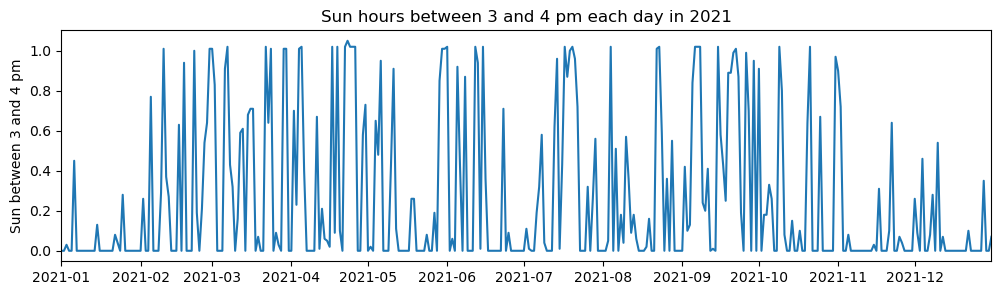

In [4]:
plt.figure(figsize=(12, 3))
# plot daily sun hours
plt.plot(daily_variables['date'], daily_variables['total_sun_3to4pm'])
plt.title('Sun hours between 3 and 4 pm each day in 2021')
plt.ylabel('Sun between 3 and 4 pm')

# convert xaxis days to months
plt.xlim(daily_variables['date'].min(), daily_variables['date'].max())

plt.show()

# ML task: predict daily sun hours based on previous 3 days

- could create 2 dataset splits: one uses december & november for testing, one uses the last 6 days in each month
- Q: do you think one of these options works better? if yes, why? if no, why not?
- Can we randomly choose 80% of input-output pairs for the training set and use the other 20% for testing?

### imports

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from utils import (create_timeseries_dataset,
                   get_test_train_split_df,
                   plot_time_series_predictions)

## Random Forest Regression

In [6]:
# split the data into training and test sets
df_train, df_test = get_test_train_split_df(daily_variables)

# create input and output matrices for the training and test timeseries datasets
X_train, y_train, y_dates_train = create_timeseries_dataset(df_train, target_column='total_sun_per_day', inputs_length=3)
X_test, y_test, y_dates_test = create_timeseries_dataset(df_test, target_column='total_sun_per_day', inputs_length=3)

In [7]:
# create and train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# calculate the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Training MSE: {mse_train:.2f}')
print(f'Test MSE: {mse_test:.2f}')

Training MSE: 1.76
Test MSE: 11.63


In [8]:
# create and train the model
model = RandomForestRegressor(max_depth=3)
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# calculate the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Training MSE: {mse_train:.2f}')
print(f'Test MSE: {mse_test:.2f}')

Training MSE: 8.04
Test MSE: 9.71


### Q*: RandomForest hyperparameters

The Random Forest seems to be heavily overfitting to the input dataset (how do we know this?). We don't expect great model performance, but this seems quite severe. Read the documentation of the [RandomForestRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and choose 2 hyperparameters which can improve this issue. test a few parameter combinations (e.g., change a parameter that defaults to 1 to 2, 5, ...). How does this affect model performance?

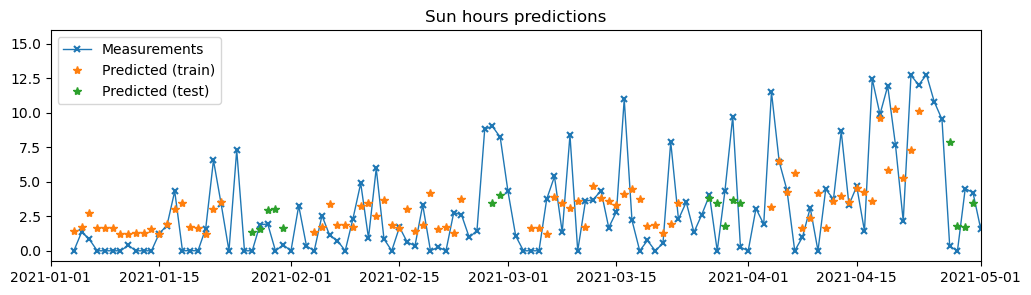

In [9]:
plot_time_series_predictions(
    y_true=daily_variables['total_sun_per_day'][3:],
    y_dates=daily_variables['date'][3:],
    y_pred_train=y_pred_train,
    y_pred_test=y_pred_test,
    y_dates_train=y_dates_train,
    y_dates_test=y_dates_test,
    xlim=(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-05-01'))
)

plt.title('Sun hours predictions')
plt.show()

## Can we improve predictions using Earth Observation Data?

[MODIS Terra](https://terra.nasa.gov/about/terra-instruments/modis)

In [ ]:
import json
from typing import Callable

import numpy as np
import torch
from loguru import logger
from torch.utils.data import Dataset


######################
##### Transforms #####
######################

import json
import numpy as np
import torch


class ToTensorTransform:
    """
    Convert numpy array to PyTorch tensor
    """

    def __init__(self, dtype=torch.float32):
        self.dtype = dtype

    def __call__(self, data, **kwargs):
        # Convert to tensor
        tensor = torch.as_tensor(data, dtype=self.dtype)
        return tensor


class MeanStdNormaliseTransform:
    def __init__(self, mean: float, std: float):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        # Convert to tensor
        data = (data - self.mean) / self.std
        return data


class NanMeanFillTransform:
    """
    Replaces NaN values in a numpy array with the mean of the non-NaN values of that image
    """

    def __init__(self, key="data"):
        self.key = key

    def __call__(self, data):
        # replace NaN values
        data = np.nan_to_num(data, nan=np.nanmean(data))
        return data

##################################
##### Sunny Oxford Transform #####
##################################

from torchvision.transforms import Compose


class SunnyOxfordModisTransform:

    """Transform pipeline for MODIS files."""

    def __init__(
        self,
        mean: float,
        std: float,
        fill_nan: bool = True,
    ):
        transforms_list = [
            MeanStdNormaliseTransform(
                mean=mean,
                std=std,
            )
        ]

        if fill_nan:
            transforms_list.append(NanMeanFillTransform())

        transforms_list.append(ToTensorTransform())

        self.transform = Compose(transforms_list)

    def __call__(self, sample):
        s = self.transform(sample)
        return s
    

################################
##### Sunny Oxford Dataset #####
################################



class SunnyOxfordDataset(Dataset):
    def _get_date_from_filename(self, filename: str) -> datetime:
        """
        Extract the date from a MODIS filename.
        """
        return datetime.strptime(filename.split("/")[-1].split(".")[0], "%Y-%m-%d")
    
    def _match_aopp_observation(self, modis_filename: str) -> dict:
        """
        Return the AOPP observation that matches the MODIS image date.
        """
        modis_date = self._get_date_from_filename(modis_filename)
        aopp_row = self.aopp_dataframe[self.aopp_dataframe["date"] == modis_date]
        if len(aopp_row) == 0:
            logger.warning(f"No AOPP observation found for {modis_date}")
            return None
        else:
            return aopp_row.to_dict(orient="records")[0]
        
    def __init__(
        self,
        modis_filenames: list[str],
        aopp_dataframe: pd.DataFrame,
        transforms: Callable | None = None,
    ):
        self.modis_filenames = modis_filenames
        self.aopp_dataframe = aopp_dataframe
        self.transforms = transforms

    def setup(self, stage):
        pass

    def prepare_data(self):
        pass

    def __getitem__(self, ind) -> np.ndarray:
        item = {}
        x = np.load(self.patches_filenames[ind])["arr_0"]
        if self.transforms is not None:
            # transforms takes a numpy array and returns a torch array
            x = self.transforms(x)
        if not isinstance(x, torch.Tensor):
            logger.error(f"Transforms did not return a torch tensor, but {type(x)}")
        item["modis_image"] = x
        item["aopp_observation"] = self._match_aopp_observation(self.modis_filenames[ind])
        return item

    def __len__(self):
        return len(self.modis_filenames)

In [ ]:
from typing import Callable

from lightning import LightningDataModule
from loguru import logger
from torch.utils.data import DataLoader


class SunnyOxfordDatamodule(LightningDataModule):
    def __init__(
        self,
        data_dir: str,
        splits_dict: dict,
        transforms: Callable | None = None,
        patches_filetype: str = "npz",
        load_parameters: bool = True,
        parameter_key: str = "multifractal_zeta_infinity",
        copy_image_channels: bool = True,
        image_channels: int = 3,
        batch_size: int = 16,
        num_workers: int = 1,
        pin_memory: bool = False,
        prefetch_factor: int = 4,
    ):
        super().__init__()
        self.save_hyperparameters(logger=False)
        self.prefetch_factor = prefetch_factor
        self.pin_memory = pin_memory

        self.data_dir = data_dir
        self.splits_dict = splits_dict

        self.transforms = transforms

        self.patches_filetype = patches_filetype
        self.load_parameters = load_parameters
        self.parameter_key = parameter_key
        self.copy_image_channels = copy_image_channels
        self.image_channels = image_channels

        self.batch_size = batch_size
        self.num_workers = num_workers

        # get all filenames in data_dir
        patch_filenames = get_list_olr_patchfiles(
            data_path=self.data_dir, ext=self.patches_filetype
        )

        logger.info(f"Found {len(patch_filenames)} files in {self.data_dir}")

        # split filenames based on train/test/val criteria
        train_patch_files = get_split(patch_filenames, splits_dict["train"])
        test_patch_files = get_split(patch_filenames, splits_dict["test"])
        val_patch_files = get_split(patch_filenames, splits_dict["val"])

        self.train_dataset = SunnyOxfordDataset(
            patches_filenames=train_patch_files,
            transforms=self.transforms,
            patches_filetype=self.patches_filetype,
            load_parameters=self.load_parameters,
            parameter_key=self.parameter_key,
            copy_image_channels=self.copy_image_channels,
            image_channels=self.image_channels,
        )

        self.test_dataset = SunnyOxfordDataset(
            patches_filenames=test_patch_files,
            transforms=self.transforms,
            patches_filetype=self.patches_filetype,
            load_parameters=self.load_parameters,
            parameter_key=self.parameter_key,
            copy_image_channels=self.copy_image_channels,
            image_channels=self.image_channels,
        )

        self.val_dataset = SunnyOxfordDataset(
            patches_filenames=val_patch_files,
            transforms=self.transforms,
            patches_filetype=self.patches_filetype,
            load_parameters=self.load_parameters,
            parameter_key=self.parameter_key,
            copy_image_channels=self.copy_image_channels,
            image_channels=self.image_channels,
        )

    def prepare_data(self):
        self.train_dataset.prepare_data()
        self.test_dataset.prepare_data()
        self.val_dataset.prepare_data()

    def setup(self, stage):
        self.train_dataset.setup(stage)
        self.test_dataset.setup(stage)
        self.val_dataset.setup(stage)

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.pin_memory,
            shuffle=True,
            persistent_workers=True,
            prefetch_factor=self.hparams.prefetch_factor,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.val_dataset,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.pin_memory,
            shuffle=False,
            persistent_workers=True,
            prefetch_factor=self.hparams.prefetch_factor,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.pin_memory,
            shuffle=False,
            persistent_workers=True,
            prefetch_factor=self.hparams.prefetch_factor,
        )

In [13]:
columns = ['date', 'time', 'filename', 'path']
modis_images = pd.read_csv('../../data/1-sunny-oxford/modis/valid_granules_for_training.csv')[columns]
# modis_images['date'] = pd.to_datetime(modis_images['date'])
modis_images.head()

,date,time,filename,path
0,2021-01-02,11:20:00,MOD021KM.A2021002.1120.061.2021002190459.hdf,2021/01/02/MOD021KM.A2021002.1120.061.20210021...
1,2021-01-04,11:05:00,MOD021KM.A2021004.1105.061.2021004190923.hdf,2021/01/04/MOD021KM.A2021004.1105.061.20210041...
2,2021-01-10,10:30:00,MOD021KM.A2021010.1030.061.2021010190550.hdf,2021/01/10/MOD021KM.A2021010.1030.061.20210101...
3,2021-01-13,11:00:00,MOD021KM.A2021013.1100.061.2021013191123.hdf,2021/01/13/MOD021KM.A2021013.1100.061.20210131...
4,2021-01-15,10:50:00,MOD021KM.A2021015.1050.061.2021015191617.hdf,2021/01/15/MOD021KM.A2021015.1050.061.20210151...


In [11]:
# input: morning satellite image (9-12 am)
# output: predicted sun hours for the day

## Adding environmental inputs

In [4]:
# input image + wind
# 3 day sun hours + temperature + wind
# study feature importance